In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path

# This code is neccessary to produce the same results every time
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.metrics import categorical_accuracy

In [2]:
risk_tolerance_data = pd.read_csv('us_input_data.csv')
risk_tolerance_data.head()
risk_tolerance_data.columns

Index(['Unnamed: 0', 'AGE07', 'EDCL07', 'MARRIED07', 'KIDS07', 'LIFECL07',
       'OCCAT107', 'INCOME07', 'RISK07', 'WSAVED07', 'SPENDMOR07',
       'NETWORTH07', 'TrueRiskTol'],
      dtype='object')

In [3]:
risk_tol_model = risk_tolerance_data.rename(columns={
    'Unnamed: 0': 'PROFILE ID',
    'AGE07': 'AGE',
    'EDCL07': 'EDUCATION',
    'MARRIED07': 'MARRIAGE',
    'LIFECL07': 'QUALITY OF LIFE',
    'KIDS07': 'KIDS',
    'OCCAT107': 'EMPLOYMENT',
    'INCOME07': 'INCOME',
    'RISK07': 'RISK TENDENCY',
    'WSAVED07': 'SAVING POTENTIAL',
    'SPENDMOR07': 'SPENDING POTENTIAL',
    'NETWORTH07': 'NET WORTH',
    'TrueRiskTol': 'TRUE RISK TOLERANCE'
})
risk_tol_model.dropna()
risk_tol_model.columns
risk_tol_model.tail()

PROFILE ID  AGE  EDUCATION  MARRIAGE  KIDS  QUALITY OF LIFE  EMPLOYMENT   
4805       19280   50          4         2     0                1           2  \
4806       19281   50          4         2     0                1           2   
4807       19282   50          4         2     0                1           2   
4808       19283   50          4         2     0                1           2   
4809       19284   50          4         2     0                1           2   

            INCOME  RISK TENDENCY  SAVING POTENTIAL  SPENDING POTENTIAL   
4805  78808.246592              2                 2                   5  \
4806  78808.246592              2                 2                   5   
4807  77743.270286              2                 2                   5   
4808  77743.270286              2                 2                   5   
4809  77743.270286              2                 2                   5   

         NET WORTH  TRUE RISK TOLERANCE  
4805  653876.35532             5.978830  
4806  655843.99086             5.941754  
4807  654911.95297             5.903461  
4808  654911.95297             5.903461  
4809  655947.55062             5.903461

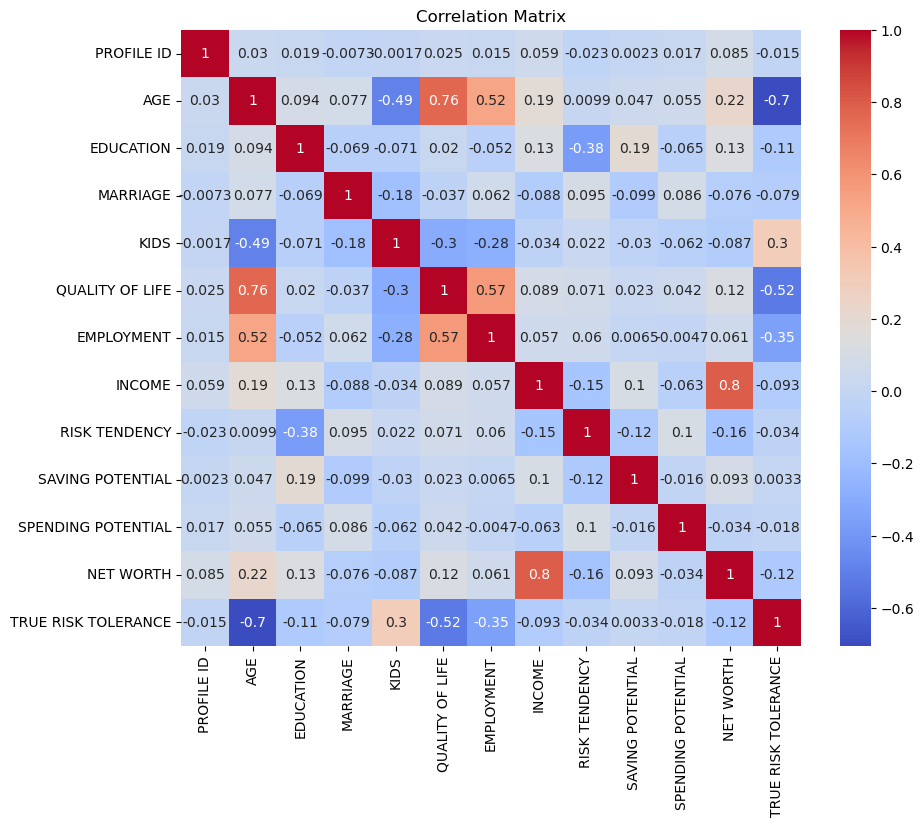

In [4]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = risk_tol_model.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Calculate the correlation between features and target variable
target_correlations = correlation_matrix['TRUE RISK TOLERANCE'].abs().sort_values(ascending=False)

# Print the correlations
print(target_correlations)

TRUE RISK TOLERANCE    1.000000
AGE                    0.704930
QUALITY OF LIFE        0.524008
EMPLOYMENT             0.352277
KIDS                   0.303377
NET WORTH              0.119655
EDUCATION              0.109487
INCOME                 0.092970
MARRIAGE               0.079372
RISK TENDENCY          0.034462
SPENDING POTENTIAL     0.017954
PROFILE ID             0.015334
SAVING POTENTIAL       0.003254
Name: TRUE RISK TOLERANCE, dtype: float64


In [6]:
# Select the top N features with the strongest correlation
num_features = 10 # Number of features to select
strongest_corr_features = target_correlations[1:num_features + 1].index
# Print the names of the selected features
print(strongest_corr_features)

Index(['AGE', 'QUALITY OF LIFE', 'EMPLOYMENT', 'KIDS', 'NET WORTH',
       'EDUCATION', 'INCOME', 'MARRIAGE', 'RISK TENDENCY',
       'SPENDING POTENTIAL'],
      dtype='object')


In [7]:
print(risk_tol_model['TRUE RISK TOLERANCE'].dtype)

float64


In [8]:
print(risk_tol_model['TRUE RISK TOLERANCE'].isnull().sum())

0


In [9]:
columns_to_keep = ['AGE', 'KIDS', 'NET WORTH' , 'INCOME', 'MARRIAGE', 'TRUE RISK TOLERANCE']
risk_tol_model = risk_tol_model[columns_to_keep]

In [10]:
print(risk_tol_model['TRUE RISK TOLERANCE'].describe())

count    4810.000000
mean       10.778694
std        15.853115
min         0.450112
25%         1.032562
50%         4.047974
75%        13.620327
max        98.604330
Name: TRUE RISK TOLERANCE, dtype: float64


In [11]:
min_value = risk_tol_model['TRUE RISK TOLERANCE'].min()
max_value = risk_tol_model['TRUE RISK TOLERANCE'].max()

count_min_max = risk_tol_model[
    (risk_tol_model['TRUE RISK TOLERANCE'] >= min_value) &
    (risk_tol_model['TRUE RISK TOLERANCE'] <= max_value)
].shape[0]

print(f"Number of data points within the range [{min_value} - {max_value}]: {count_min_max}") 

Number of data points within the range [0.4501123757081319 - 98.60433006234564]: 4810


In [12]:
data_points = risk_tol_model[(risk_tol_model['TRUE RISK TOLERANCE'] >= 0.45) & (risk_tol_model['TRUE RISK TOLERANCE'] <= 98.4)]
print(data_points)

      AGE  KIDS     NET WORTH        INCOME  MARRIAGE  TRUE RISK TOLERANCE
0      47     0  352641.71130  56443.744181         1             6.947439
1      47     0  340525.21881  56443.744181         1             6.223158
2      47     0  348696.08426  56443.744181         1             6.676709
3      47     0  351802.87720  56443.744181         1             6.286854
4      47     0  358958.85696  56443.744181         1             6.177016
...   ...   ...           ...           ...       ...                  ...
4805   50     0  653876.35532  78808.246592         2             5.978830
4806   50     0  655843.99086  78808.246592         2             5.941754
4807   50     0  654911.95297  77743.270286         2             5.903461
4808   50     0  654911.95297  77743.270286         2             5.903461
4809   50     0  655947.55062  77743.270286         2             5.903461

[4805 rows x 6 columns]


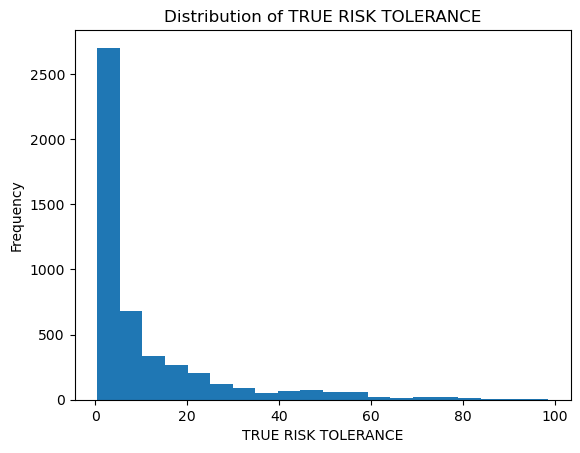

In [13]:
# Plot a histogram to visualize the distribution
plt.hist(risk_tol_model['TRUE RISK TOLERANCE'], bins=20)
plt.xlabel('TRUE RISK TOLERANCE')
plt.ylabel('Frequency')
plt.title('Distribution of TRUE RISK TOLERANCE')
plt.show()

# Calculate the value counts for each level
value_counts = risk_tol_model['TRUE RISK TOLERANCE'].value_counts().sort_index()

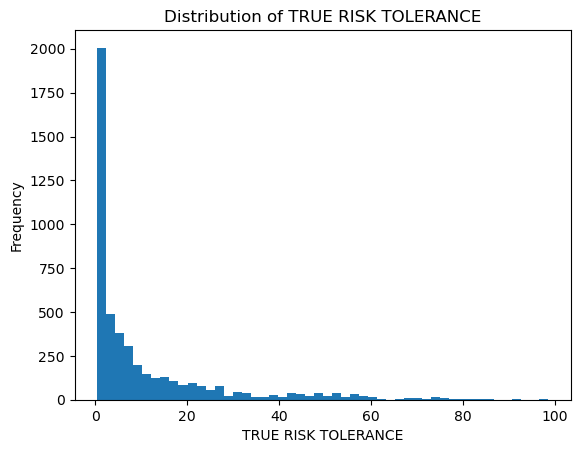

In [14]:
# Set the number of bins based on the data range and granularity desired
num_bins = 50

# Plot a histogram to visualize the distribution
plt.hist(risk_tol_model['TRUE RISK TOLERANCE'], bins=num_bins)
plt.xlabel('TRUE RISK TOLERANCE')
plt.ylabel('Frequency')
plt.title('Distribution of TRUE RISK TOLERANCE')
plt.show()

In [15]:
# Define the ranges and labels
ranges = [(0, 6), (7, 15), (16, 35), (36, 74), (75, 100)]
labels = ['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']

# Add the 'RISK TOLERANCE SCORE' column
risk_tol_model['RISK TOLERANCE SCORE'] = pd.cut(risk_tol_model['TRUE RISK TOLERANCE'], bins=[r[0] for r in ranges] + [ranges[-1][1]], labels=labels)

# Display the updated DataFrame with risk profiles
#print(risk_tol_model[['TRUE RISK TOLERANCE', 'RISK TOLERANCE SCORE']])

In [16]:
risk_tol_model.head()

AGE  KIDS     NET WORTH        INCOME  MARRIAGE  TRUE RISK TOLERANCE   
0   47     0  352641.71130  56443.744181         1             6.947439  \
1   47     0  340525.21881  56443.744181         1             6.223158   
2   47     0  348696.08426  56443.744181         1             6.676709   
3   47     0  351802.87720  56443.744181         1             6.286854   
4   47     0  358958.85696  56443.744181         1             6.177016   

  RISK TOLERANCE SCORE  
0        Very Low Risk  
1        Very Low Risk  
2        Very Low Risk  
3        Very Low Risk  
4        Very Low Risk

In [17]:
# Count the number of data points for each risk tolerance score
counts = risk_tol_model['RISK TOLERANCE SCORE'].value_counts()
print(counts)

RISK TOLERANCE SCORE
Very Low Risk     2980
Low Risk           795
Moderate Risk      624
High Risk          372
Very High Risk      39
Name: count, dtype: int64


In [18]:
from sklearn.ensemble import RandomForestClassifier
#Prepare the data
X = risk_tol_model[['AGE', 'KIDS', 'NET WORTH', 'INCOME', 'MARRIAGE']]
y = risk_tol_model['RISK TOLERANCE SCORE']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

model_name = 'Random Forest Classifier'

#Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_train.value_counts()

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=rf_classifier.classes_, index=rf_classifier.classes_)
print("Confusion Matrix:")
print(cm_df)

Accuracy: 0.9792186201163757
y_train value counts:
RISK TOLERANCE SCORE
Very Low Risk     2233
Low Risk           599
Moderate Risk      467
High Risk          281
Very High Risk      27
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       0.96      0.97      0.96        91
      Low Risk       0.94      0.97      0.96       196
 Moderate Risk       0.98      0.96      0.97       157
Very High Risk       1.00      0.83      0.91        12
 Very Low Risk       0.99      0.99      0.99       747

      accuracy                           0.98      1203
     macro avg       0.97      0.94      0.96      1203
  weighted avg       0.98      0.98      0.98      1203

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk              88         0              3               0  \
Low Risk                1       191              0               0   
Moderate Risk           1    

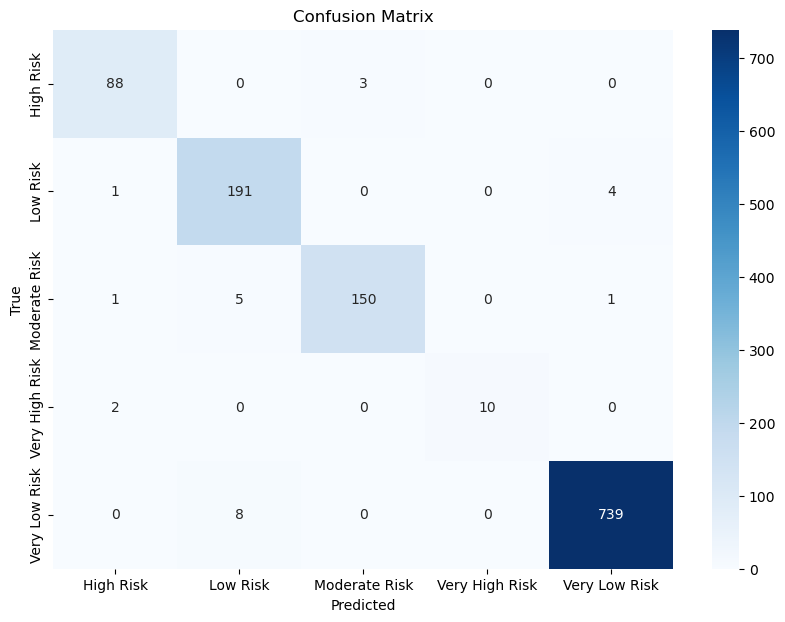

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [20]:
#Training model with RandomOverSampler 
from imblearn.over_sampling import RandomOverSampler

# Instantiate a RandomOversampler instance
random_oversampler = RandomOverSampler(random_state=42)

#Perform oversampling with RandomOverSampler
X_oversampled, y_oversampled = random_oversampler.fit_resample(X_train, y_train)
y_oversampled.value_counts()

#Create and train the Random Forest Classifier model
random_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
random_balanced.fit(X_oversampled, y_oversampled)

# Assign a name to the model
model_name = 'Random Forest Classifier Oversampler'

#Make predictions on the test set
y_pred = random_balanced.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm_ros = confusion_matrix(y_test, y_pred)
cm_ros_df = pd.DataFrame(cm_ros, columns=random_balanced.classes_, index=random_balanced.classes_)
print("Confusion Matrix:")
print(cm_ros_df)

Accuracy: 0.9808811305070657
Classification Report:
                precision    recall  f1-score   support

     High Risk       0.97      0.96      0.96        91
      Low Risk       0.95      0.97      0.96       196
 Moderate Risk       0.97      0.96      0.97       157
Very High Risk       1.00      0.92      0.96        12
 Very Low Risk       0.99      0.99      0.99       747

      accuracy                           0.98      1203
     macro avg       0.98      0.96      0.97      1203
  weighted avg       0.98      0.98      0.98      1203

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk              87         0              4               0  \
Low Risk                1       191              0               0   
Moderate Risk           1         4            151               0   
Very High Risk          1         0              0              11   
Very Low Risk           0         7              0               0   

  

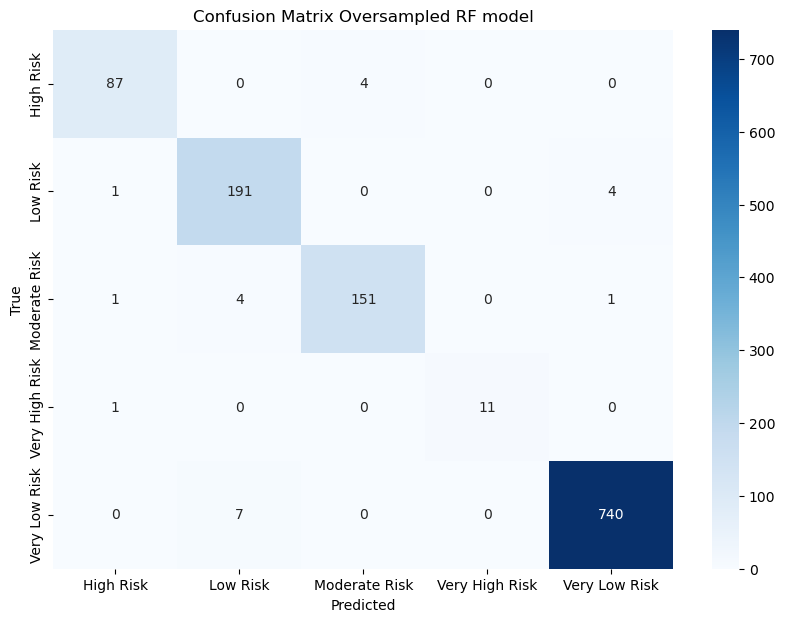

In [21]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ros, annot=True, cmap="Blues", fmt="d", xticklabels=random_balanced.classes_, yticklabels=random_balanced.classes_)
plt.title("Confusion Matrix Oversampled RF model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [22]:
#Training model with SVC
from sklearn.svm import SVC

# Utilizing the balanced dataset from the random oversampler model  (X_oversampled and y_oversampled are the oversampled data)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=42)

# Step 3: Create and train the SVM model
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)
y_train.value_counts()

#Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

#Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Print confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm_df = pd.DataFrame(cm_svm, columns=svm_classifier.classes_, index=svm_classifier.classes_)
print("Confusion Matrix:")
print(cm_svm_df)

Accuracy: 0.2722063037249284
y_train value counts:
RISK TOLERANCE SCORE
Very High Risk    1697
Very Low Risk     1679
Moderate Risk     1679
High Risk         1662
Low Risk          1656
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       1.00      0.01      0.02       571
      Low Risk       0.27      0.05      0.08       577
 Moderate Risk       0.00      0.00      0.00       554
Very High Risk       0.23      1.00      0.37       536
 Very Low Risk       0.70      0.34      0.46       554

      accuracy                           0.27      2792
     macro avg       0.44      0.28      0.19      2792
  weighted avg       0.44      0.27      0.18      2792

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk               6         0              0             554  \
Low Risk                0        28             22             476   
Moderate Risk           0    

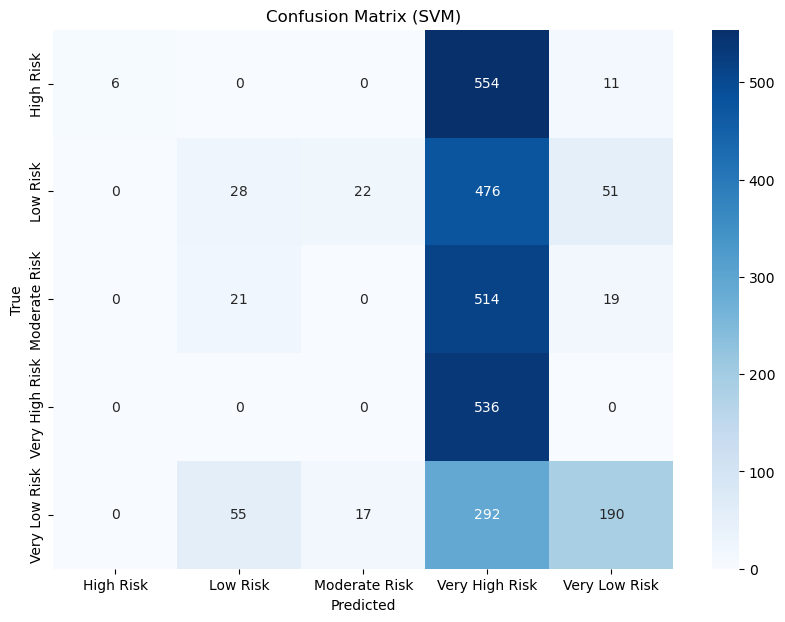

In [23]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy: 0.9617622610141313
y_train value counts:
RISK TOLERANCE SCORE
Very Low Risk     2233
Low Risk           599
Moderate Risk      467
High Risk          281
Very High Risk      27
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       0.94      0.93      0.94        91
      Low Risk       0.92      0.91      0.92       196
 Moderate Risk       0.92      0.92      0.92       157
Very High Risk       1.00      0.92      0.96        12
 Very Low Risk       0.98      0.99      0.99       747

      accuracy                           0.96      1203
     macro avg       0.95      0.93      0.94      1203
  weighted avg       0.96      0.96      0.96      1203

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk              85         1              5               0  \
Low Risk                1       179              7               0   
Moderate Risk           3    

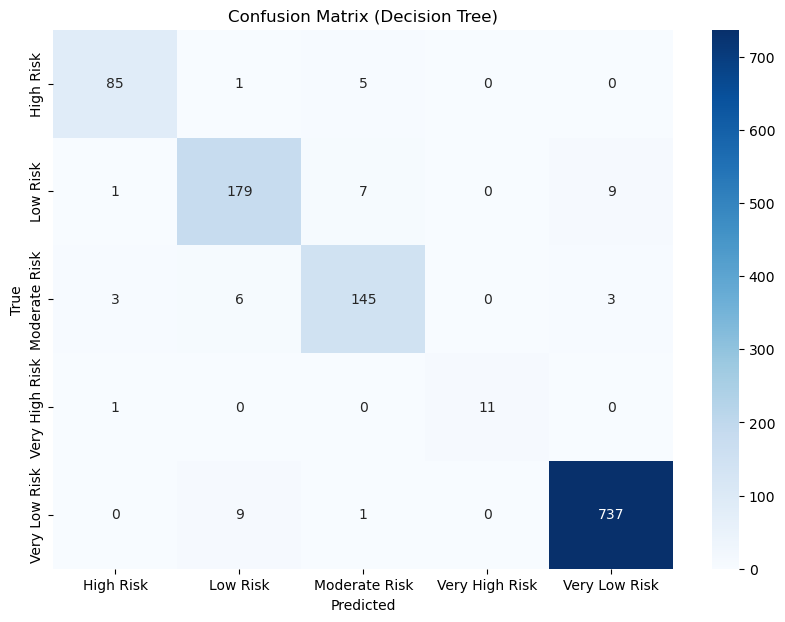

In [24]:
from sklearn.tree import DecisionTreeClassifier

#USING ORIGINAL DATASET IMBALANCED

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Create and train the Decision Tree Classifier model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

#Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test)

#Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy_dt)

#Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

#Print confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt_df = pd.DataFrame(cm_dt, columns=dt_classifier.classes_, index=dt_classifier.classes_)
print("Confusion Matrix:")
print(cm_dt_df)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dt, annot=True, cmap="Blues", fmt="d", xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy: 0.9914040114613181
y_train value counts:
RISK TOLERANCE SCORE
Very High Risk    1697
Very Low Risk     1679
Moderate Risk     1679
High Risk         1662
Low Risk          1656
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       1.00      1.00      1.00       571
      Low Risk       0.98      0.99      0.98       577
 Moderate Risk       0.99      1.00      1.00       554
Very High Risk       1.00      1.00      1.00       536
 Very Low Risk       0.99      0.97      0.98       554

      accuracy                           0.99      2792
     macro avg       0.99      0.99      0.99      2792
  weighted avg       0.99      0.99      0.99      2792

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk             571         0              0               0  \
Low Risk                0       572              0               0   
Moderate Risk           0    

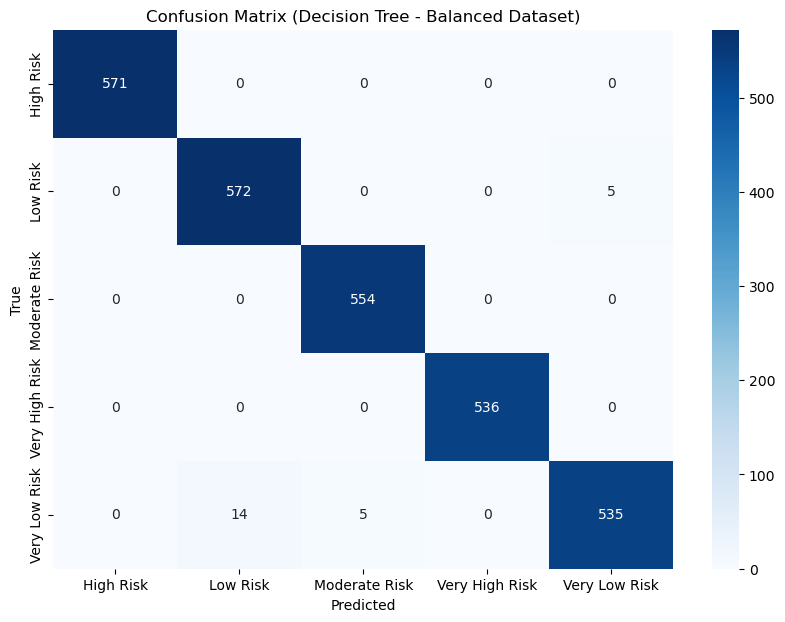

In [25]:
#TRAINING MODEL WITH DECISION TREE AND OVERSAMPLED DATA SET 

#(X_oversampled and y_oversampled are the balanced data from the random oversampler)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=42)

#Create and train the Decision Tree Classifier model
dtree_balanced = DecisionTreeClassifier(random_state=42)
dtree_balanced.fit(X_train, y_train)

# Assign a name to the model
model_name = 'Decision Tree Classifier'

#Make predictions on the test set
y_pred = dtree_balanced.predict(X_test)

#Evaluate the model
accuracy_dt_balanced = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_dt_balanced)

# Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm_dt_balanced = confusion_matrix(y_test, y_pred)
cm_dt_balanced_df = pd.DataFrame(cm_dt_balanced, columns=dtree_balanced.classes_, index=dtree_balanced.classes_)
print("Confusion Matrix:")
print(cm_dt_balanced_df)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dt_balanced, annot=True, cmap="Blues", fmt="d", xticklabels=dtree_balanced.classes_, yticklabels=dtree_balanced.classes_)
plt.title("Confusion Matrix (Decision Tree - Balanced Dataset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy: 0.8994181213632585
y_train value counts:
RISK TOLERANCE SCORE
Very Low Risk     2233
Low Risk           599
Moderate Risk      467
High Risk          281
Very High Risk      27
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       0.89      0.80      0.84        91
      Low Risk       0.75      0.77      0.76       196
 Moderate Risk       0.80      0.78      0.79       157
Very High Risk       1.00      0.67      0.80        12
 Very Low Risk       0.96      0.98      0.97       747

      accuracy                           0.90      1203
     macro avg       0.88      0.80      0.83      1203
  weighted avg       0.90      0.90      0.90      1203

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk              73         2             15               0  \
Low Risk                2       150             16               0   
Moderate Risk           3    

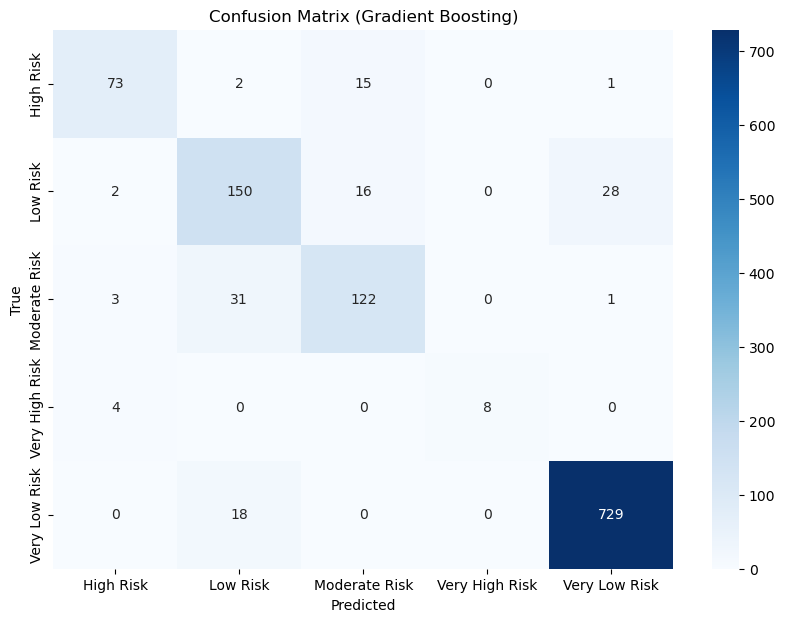

In [26]:
#Training model with GradientBoosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Create and train the Gradient Boosting Classifier model
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

#Make predictions on the test set
y_pred_gb = gb_classifier.predict(X_test)

#Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy:", accuracy_gb)

#Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Print confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb_df = pd.DataFrame(cm_gb, columns=gb_classifier.classes_, index=gb_classifier.classes_)
print("Confusion Matrix:")
print(cm_gb_df)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gb, annot=True, cmap="Blues", fmt="d", xticklabels=gb_classifier.classes_, yticklabels=gb_classifier.classes_)
plt.title("Confusion Matrix (Gradient Boosting)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy: 0.9269340974212035
y_train value counts:
RISK TOLERANCE SCORE
Very High Risk    1697
Very Low Risk     1679
Moderate Risk     1679
High Risk         1662
Low Risk          1656
Name: count, dtype: int64
Classification Report:
                precision    recall  f1-score   support

     High Risk       0.97      0.93      0.95       571
      Low Risk       0.84      0.93      0.88       577
 Moderate Risk       0.89      0.89      0.89       554
Very High Risk       0.99      1.00      1.00       536
 Very Low Risk       0.96      0.89      0.93       554

      accuracy                           0.93      2792
     macro avg       0.93      0.93      0.93      2792
  weighted avg       0.93      0.93      0.93      2792

Confusion Matrix:
                High Risk  Low Risk  Moderate Risk  Very High Risk   
High Risk             531         3             32               4  \
Low Risk                6       535             25               0   
Moderate Risk          13    

<function matplotlib.pyplot.show(close=None, block=None)>

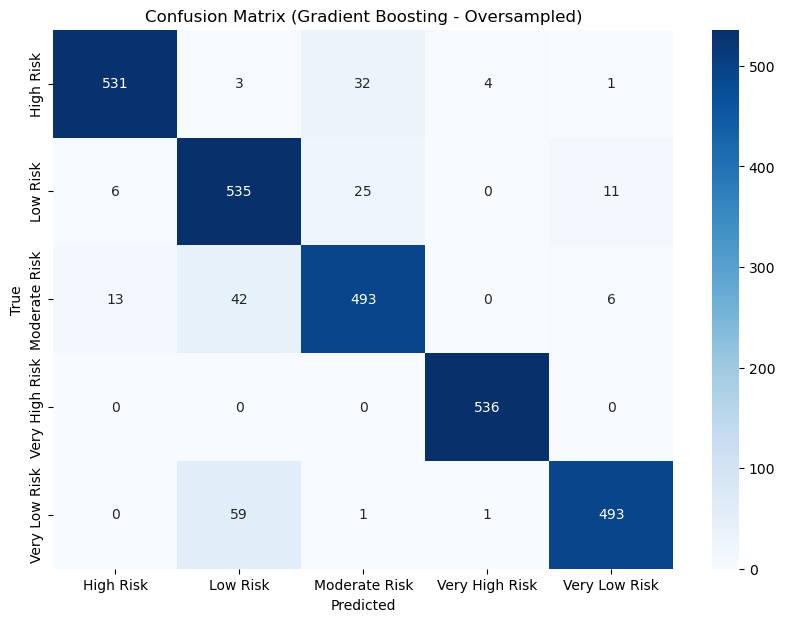

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

#TRAINING MODEL WITH DECISION TREE AND OVERSAMPLED DATA SET 

#Prepare the data (X_oversampled and y_oversampled are the balanced data from the random oversampler)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=42)

#Create and train the Gradient Boosting Classifier model
gradient_balanced = GradientBoostingClassifier(random_state=42)
gradient_balanced.fit(X_train, y_train)

# Assign a name to the model
model_name = 'Gradient Boosting Classifier'

#Make predictions on the test set
y_pred = gradient_balanced.predict(X_test)

#Evaluate the model
accuracy_gb_balanced = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_gb_balanced)

#Print value counts for y_train
print("y_train value counts:")
print(y_train.value_counts())

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Print confusion matrix
cm_gb_balanced = confusion_matrix(y_test, y_pred)
cm_gb_balanced_df = pd.DataFrame(cm_gb_balanced, columns=gradient_balanced.classes_, index=gradient_balanced.classes_)
print("Confusion Matrix:")
print(cm_gb_balanced_df)

#Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gb_balanced, annot=True, cmap="Blues", fmt="d", xticklabels=gradient_balanced.classes_, yticklabels=gradient_balanced.classes_)
plt.title("Confusion Matrix (Gradient Boosting - Oversampled)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
113/113 [==============================] - 0s 827us/step - loss: 1347369.1250 - accuracy: 0.3768
Epoch 2/10
113/113 [==============================] - 0s 707us/step - loss: 72413.0781 - accuracy: 0.5875
Epoch 3/10
113/113 [==============================] - 0s 744us/step - loss: 38040.0352 - accuracy: 0.6005
Epoch 4/10
113/113 [==============================] - 0s 774us/step - loss: 28562.3281 - accuracy: 0.5658
Epoch 5/10
113/113 [========

C:\Users\resup\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\resup\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\resup\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


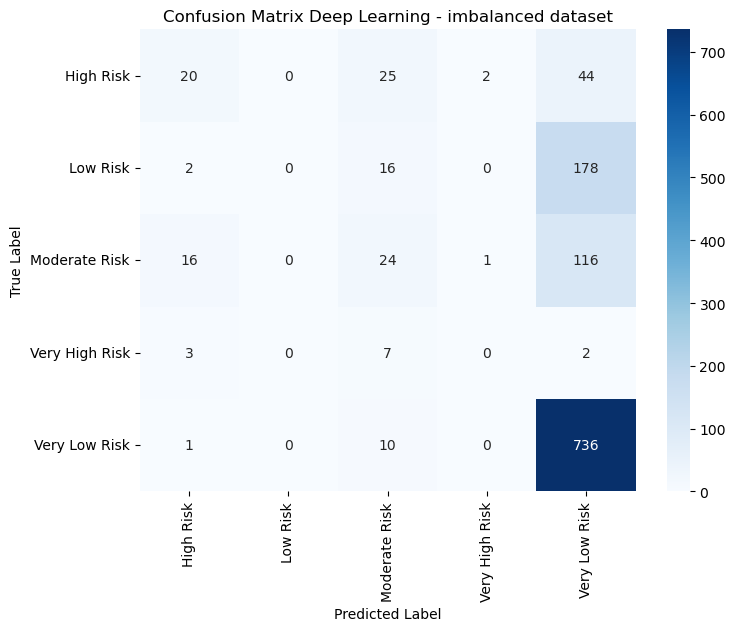

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define your data and labels
X = risk_tol_model[['AGE', 'KIDS', 'NET WORTH', 'INCOME', 'MARRIAGE']]
y = risk_tol_model['RISK TOLERANCE SCORE']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Convert the encoded labels to one-hot encoded format
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(5,)))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert the encoded labels back to the original categories
y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred)

print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

# Compute confusion matrix
confusion_mat = confusion_matrix(y_test_original, y_pred_original)
confusion_df = pd.DataFrame(confusion_mat, index=label_encoder.classes_, columns=label_encoder.classes_)

# Print confusion matrix as a DataFrame
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Deep Learning - imbalanced dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                192       
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
349/349 [==============================] - 0s 727us/step - loss: 294471.5000 - accuracy: 0.3435
Epoch 2/10
349/349 [==============================] - 0s 694us/step - loss: 35145.7227 - accuracy: 0.3277
Epoch 3/10
349/349 [==============================] - 0s 710us/step - loss: 21293.7637 - accuracy: 0.3627
Epoch 4/10
349/349 [==============================] - 0s 686us/step - loss: 19737.3359 - accuracy: 0.3732
Epoch 5/10
349/349 [=======

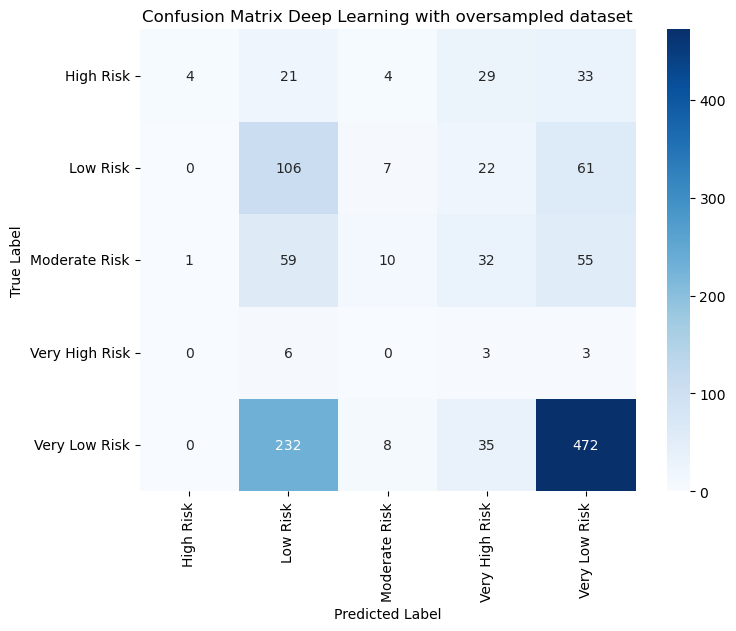

In [29]:
from imblearn.over_sampling import RandomOverSampler

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Define the model architecture
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(5,)))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with the oversampled data
history = model.fit(X_train_balanced, y_train_balanced, epochs=10, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert the encoded labels back to the original categories
y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred)

print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

# Compute confusion matrix
confusion_mat = confusion_matrix(y_test_original, y_pred_original)
confusion_df = pd.DataFrame(confusion_mat, index=label_encoder.classes_, columns=label_encoder.classes_)

# Print confusion matrix as a DataFrame
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Deep Learning with oversampled dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
import pickle
import os

In [31]:
filename = 'models/gradient_balanced.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gradient_balanced, file)

In [32]:
with open(filename, 'rb') as file:
    model = pickle.load(file)

In [33]:
def load_model(model_name):
    with open('models/' + model_name + '.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

In [34]:
load_model('gradient_balanced')

GradientBoostingClassifier(random_state=42)

In [35]:
# defining parameters of robo user input data
def build_df(age, kids, net_worth, income, marriage):  
    if marriage.lower() == 'yes':
        marriage = 1
    elif marriage.lower() == 'no':
        marriage = 2
    user = {'AGE':age, 'KIDS':kids, 'NET WORTH':net_worth, 'INCOME':income, 'MARRIAGE':marriage}
    df = pd.DataFrame(user, index = [0])
    return df

#loads trained model
def load_model(model_name):
    with open('models/' + model_name + '.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

def predict_risk_score(model, df):
    risk_level = model.predict(df)
    return risk_level[0]

In [36]:
model_name = 'gradient_balanced'
model = load_model(model_name)

age = 36
kids = 0
net_worth = 100000
income = 80000
marriage = 'no'
df = build_df(age, kids, net_worth, income, marriage)



In [37]:
model_name = 'gradient_balanced'
model = load_model(model_name)

age = 36
kids = 0
net_worth = 100000
income = 80000
marriage = 'no'
df = build_df(age, kids, net_worth, income, marriage)
df

predict_risk_score(model,df)

'Very High Risk'

In [38]:
import os
def list_saved_models():
    saved_models = []
    directory = 'models'
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            model_name = filename[:-4] 
            saved_models.append(model_name)
    return saved_models

saved_models = list_saved_models()
print(saved_models)

['dtree_balanced', 'gradient_balanced', 'random_balanced']


In [39]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    return accuracy

accuracy = evaluate_model(model, X, y)
print('Model Accuracy:', accuracy)

Model Accuracy: 0.9058212058212058


In [40]:
def get_feature_importances(model, X):
    feature_importances = model.feature_importances_
    importances_dict = dict(zip(X.columns, feature_importances))
    return importances_dict

feature_importances = get_feature_importances(model, df)
print(feature_importances)

{'AGE': 0.49054518504992206, 'KIDS': 0.04563244280995406, 'NET WORTH': 0.28115083723689555, 'INCOME': 0.17953679836490133, 'MARRIAGE': 0.0031347365383270582}
